# The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

This notebook will be dedicated to estimating parameters within some __simulated data__.

In [57]:
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
# from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
# import functools

import siuba as s
from siuba import _
# from dfply import *
%run -i 'model_helpers.py'

## Simulate data

## create and fit model

Easiest to focus on fitting for a single participant

In [394]:
def calc_prob_sim(trial, theta):
    ## compute implied subj. probability from latent theta and trial type
    ## this is a vectorized solution: https://bit.ly/2P6mMcD
    
    return trial_funcs[trial](theta)

def sim_sampling(prob, d, k):
    p_bs = calc_ptn_prob(prob, d)
    
    return np.random.beta(p_bs*k, (1-p_bs)*k)


def sim_bayesian_sampler(trial_types, n_participants, n_blocks, params):
    from dfply import mutate, X
    n_trial_types = len(trial_types)
    trials = trial_types*n_blocks
    conds = np.tile(np.array(list(range(0,n_blocks))).repeat(len(trial_types)), n_participants)
    blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

    all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
    all_thetas = make_thetas(n_participants)
    all_trials = trials*n_participants
    all_blocks = blocks*n_participants

    sim_data = pd.DataFrame(
        data = {
            "ID": all_participants,
            "querytype": all_trials, 
            "block": all_blocks,
            "condition": conds
        }) >> mutate(
            conjdisj_trial = X.querytype.apply(is_conjdisj),
            d_base = X.ID.apply(lambda x: params["d_base"][x]),
            d_delta = X.ID.apply(lambda x: params["d_delta"][x]),
        theta = X.ID.apply(lambda x: all_thetas[x])
        ) >> mutate(d = X.d_base + X.d_delta * (1-X.conjdisj_trial))

    sim_data["prob"] = sim_data.apply(lambda x: calc_prob_sim(x.querytype, x.theta), axis=1)
    sim_data["response"] = sim_data.apply(lambda x: sim_sampling(x.prob, x.d, params["k"]), axis=1)
    
    return sim_data


trial_types = [
    'A',
    'AandB',
    'AandnotB',
    'AgB',
    'AgnotB',
    'AorB',
    'AornotB',
    'B',
    'BgA',
    'BgnotA',
    'notA',
    'notAandB',
    'notAandnotB',
    'notAgB',
    'notAgnotB',
    'notAorB',
    'notAornotB',
    'notB',
    'notBgA',
    'notBgnotA'
    ]

N = 5
N_blocks = 4
params = {
    "d_base": np.random.beta(1,1,N)/3.0,
    "d_delta":np.zeros(N),
    "k":50
}

print(params["d_base"])
sim_data = sim_bayesian_sampler(trial_types, n_participants=N, n_blocks=N_blocks, params=params)
sim_data = (
    sim_data >>
    s.ungroup() >>
    s.mutate(
        true_response = _.response,
        response = np.round(_.true_response*10)/10.
    ) >>
    s.mutate(response = _.response.replace({0:.001, 1:.999}))
)


print(sim_data.shape)
print(min(sim_data.response), max(sim_data.response))
sim_data.head()

[0.06650772 0.32356716 0.20422287 0.31288411 0.19117845]
(400, 12)
0.001 0.9


,ID,querytype,block,condition,conjdisj_trial,d_base,d_delta,theta,d,prob,response,true_response
0,0,A,0,0,0,0.066508,0.0,"[0.041345450594609534, 0.3438111289772113, 0.0...",0.066508,0.38515657,0.4,0.425177
1,0,AandB,0,0,1,0.066508,0.0,"[0.041345450594609534, 0.3438111289772113, 0.0...",0.066508,0.04134545,0.1,0.051716
2,0,AandnotB,0,0,1,0.066508,0.0,"[0.041345450594609534, 0.3438111289772113, 0.0...",0.066508,0.34381112,0.4,0.406040
3,0,AgB,0,0,0,0.066508,0.0,"[0.041345450594609534, 0.3438111289772113, 0.0...",0.066508,0.63464457,0.6,0.593928
4,0,AgnotB,0,0,0,0.066508,0.0,"[0.041345450594609534, 0.3438111289772113, 0.0...",0.066508,0.3677704,0.4,0.361405


In [395]:
X_data, y_data = make_model_data(sim_data) # see data_helpers.py

In [396]:

def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


def bayesian_sampler_simple(data, y=None):

    rounded_to = .1
    
    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(50)) # noise parameter

    with numpyro.plate("subj", n_Ps):
        ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    d_lin = ds[subj]
    d = sigmoid(d_lin)/3.
    
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        
        y_err = numpyro.sample("y_err", dist.Beta(1,1))
        y_err = (y_err - .50)*rounded_to
        
        # # gelman rounding hack <-- pretty sure this is weird/broken
        # y_true = numpyro.sample("y_true", dist.Beta(p_bs*k, (1-p_bs)*k))
        # yhat = numpyro.sample("y_hat", dist.Normal(y_true + y_err, .001), obs=y)
        
        ## "robust" rounding model
        # y_true = p_bs
        # numpyro.deterministic("y_true", y_true)
        # yhat = numpyro.sample("y_hat", dist.StudentT(1, y_true + y_err, .001), obs=y)
        
##        Gelman solution <-- pretty sure this is what is in stan manual
        true_obs = y + y_err if y is not None else None
        yhat = numpyro.sample("y_hat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=true_obs)
    
    return yhat

In [403]:
from numpyro.infer.initialization import init_to_value, init_to_feasible

mcmc_bs_simple = MCMC(NUTS(bayesian_sampler_simple, target_accept_prob=.80), 
               num_warmup=500, 
               num_samples=500, 
               num_chains=2)

mcmc_bs_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [404]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data) # see model_helpers.py
print("num divergences =", count_divergences(az_data_bs_simple))
az.summary(az_data_bs_simple, var_names=['d_base', 'k'])

num divergences = 7


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base[0],-1.617,0.355,-2.242,-0.964,0.021,0.015,249.0,475.0,1.00
d_base[1],1.435,0.426,0.680,2.217,0.024,0.018,378.0,357.0,1.00
d_base[2],0.942,0.476,0.168,1.909,0.033,0.024,229.0,319.0,1.02
d_base[3],3.267,0.861,1.750,4.901,0.042,0.031,471.0,506.0,1.01
d_base[4],0.134,0.251,-0.291,0.621,0.012,0.009,427.0,606.0,1.00
k,48.663,4.210,41.465,57.338,0.179,0.127,548.0,700.0,1.00


In [411]:
z = az.summary(az_data_bs_simple, var_names=['d_base', 'k'])
print(params["d_base"])
sigmoid(z["mean"][0:N])/3.

[0.06650772 0.32356716 0.20422287 0.31288411 0.19117845]


DeviceArray([0.05520634, 0.2692264 , 0.23983449, 0.32109305, 0.17781664],            dtype=float32)

Participant mean response corr =  0.939
Query-level corr 0.936


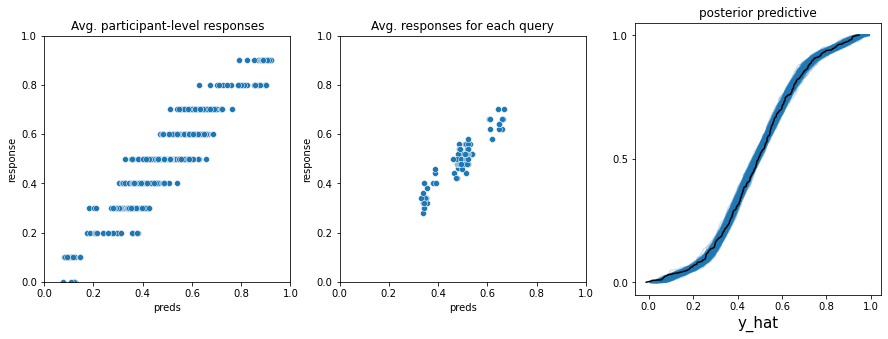

In [412]:
def plot_model_preds(orig_data, model_data):
    from matplotlib import pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].set_xlim(0,1)
    axes[1].set_xlim(0,1)
    axes[0].set_ylim(0,1)
    axes[1].set_ylim(0,1)
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)
#     fig.suptitle('Model')

    d = orig_data
    d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).y_hat # 
    # d["preds"] = model_data.posterior.mean(dim=['chain', 'draw']).y_true # 
    print("Participant mean response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
    sns.scatterplot(ax = axes[0], x = d.preds, y = d.response)

    trial_df = (d
                .groupby(["querytype", "condition"])
                .agg({"preds":"mean", "response":"mean"})
               )
    print("Query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
    sns.scatterplot(ax = axes[1], x = trial_df.preds, y = trial_df.response)
    az.plot_ppc(ax=axes[2], data=model_data, data_pairs={"y":"yhat"}, kind="cumulative", num_pp_samples=500, legend=False)
    axes[0].set_title("Avg. participant-level responses")    
    axes[1].set_title("Avg. responses for each query")
    axes[2].set_title("posterior predictive")

plot_model_preds(sim_data, az_data_bs_simple)

Some quick notes 5/12/21, 5:28 PM

Computing the "true response" and passing that with the `obs` argument seems to do the best. I've observed that if you just ignore rounding, you can overestimate $k$ in the simulated data. It's just a nuisance/noise parameter, but I would worry this could suggest there are other biases that are less obvious but could matter. So doing something about rounding error seems important.

If you add a latent "true_y" variable with its own noise you get back reasonable parameters, but the model outputs are always giving a perfect fit to the data, even when the underlying data are truly noisy. So that doesn't seem right. I'm not exactly sure what's going on, but there's clearly an issue. 

The "robust" idea sort of works, but I don't think it's a good idea for real-world use. I don't think it's a very good idea because it has no mechanism for noise in responses other than the rounding. But that's plainly not going to be correct. The t-distribution isn't flat enough in the tails to manage things. maybe some sort of mixture would work but that's just a huge pain and still not right.

In [92]:
# def bayesian_sampler_complex(data, y=None):

#     # Data processing
#     trial, subj, cond = data["trial"], data["subj"], data["cond"]
#     n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
#     # setup "design matrix" (of sorts)
#     X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
#     not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

#     # population level parameters/priors
# #     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
#     k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter

#     # subject-level parameters/priors 
#     with numpyro.plate("subj", n_Ps):
#         betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
#         N_deltas = numpyro.sample("N_delta", dist.HalfCauchy(10))
#         N_primes = numpyro.sample("N_prime", dist.HalfCauchy(10))
        
#     # subject/query-level parameters/priors
#     with numpyro.plate("cond", n_Ps*n_conds):
#         thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#     # Model "guts"
#     N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj # they required N be at least 1, no pooling for now
    
#     beta = betas[subj]
#     theta_ind = ((subj*2)+cond)
#     theta = thetas[theta_ind,:]
        
#     numerator = jnp.sum(theta*X_num, axis=-1)
#     denom = jnp.sum(theta*X_denom, axis=-1)
#     pi = jnp.divide(numerator, denom)
#     p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
#     # Likelihood
#     with numpyro.plate("data", len(trial)):
# #         yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
#     return yhat

def sigmoid(x):  
    return jnp.exp(-jnp.logaddexp(0, -x)) # numerically stable

def bayesian_sampler_complex(data, y=None):
    ## reparameterized
    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter
#     betas = numpyro.sample("betas", dist.Normal(0, 1.72)) # roughly uniform after sigmoid()
# #     beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(3))
    
#     N_primes = numpyro.sample("N_primes", dist.Normal(0, 1.5))
#     N_deltas = numpyro.sample("N_deltas", dist.Normal(0, 1.5))
#     N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(1))
#     N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(1))

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta", dist.Normal(0, 1.72))
        N_deltas = numpyro.sample("N_delta", dist.Normal(0, 3))
        N_primes = numpyro.sample("N_prime", dist.Normal(0, 3))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    

    # sigmoid() constrains beta to [0,1]
    beta = sigmoid(betas[subj])
    
    # exp() needed to constrain N positive
    N_lin = N_primes[subj] + 1*N_deltas[subj] * not_conjdisj
    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [93]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=1000, 
               num_samples=1000, 
               num_chains=1)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [00:06<00:00, 574.07it/s, 63 steps of size 1.10e-01. acc. prob=0.95] 


In [94]:
mcmc_bs.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
N_delta[0]      1.38      1.98      1.49     -1.84      4.66    620.38      1.00
N_prime[0]     -2.31      1.65     -2.05     -4.85      0.12    756.13      1.00
   beta[0]      0.88      1.05      0.66     -0.65      2.48    718.37      1.00
         k     37.99      9.05     37.42     23.82     52.39   1507.40      1.00
theta[0,0]      0.54      0.06      0.54      0.44      0.64    988.10      1.00
theta[0,1]      0.05      0.03      0.05      0.00      0.09    777.40      1.00
theta[0,2]      0.04      0.03      0.04      0.00      0.09    752.70      1.00
theta[0,3]      0.36      0.05      0.36      0.29      0.45   1642.32      1.00
theta[1,0]      0.45      0.05      0.45      0.36      0.54   1141.19      1.00
theta[1,1]      0.05      0.03      0.04      0.00      0.09    736.36      1.00
theta[1,2]      0.04      0.03      0.03      0.00      0.07    881.07      1.00
theta[1,3]      0.47      0

In [11]:
import arviz as az

numpyro_data = az.from_numpyro(mcmc_bs)

az.waic(numpyro_data)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic   770.81    22.40
p_waic      128.00        -

There has been a warning during the calculation. Please check the results.

Posterior samples for $N$ and $\beta$ are highly correlated but they are still fairly well-identified, with the means getting the right answers.

Combining $N$ and $\beta$ to calculate $D$ shows that this is also correct.

true d =  0.029411764705882353


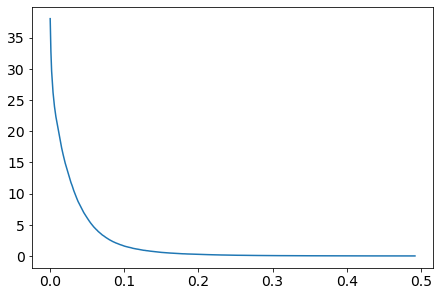

In [17]:
# can combine to form D
beta_post = numpyro_data.posterior.beta
N_post = numpyro_data.posterior.N_delta + numpyro_data.posterior.N_prime

d_post = beta_post/(N_post+2*beta_post)

az.plot_dist(d_post)
print("true d = ", .5/(16+1))

# PT+N simulations

This isn't quite working, I can't seem to get the parameters back out.

In [284]:

params_ptn = {
    "d_base": {k: .03 for k in range(0,n_participants)},
    "d_delta": {k: .2 for k in range(0,n_participants)},
    "k":40
}

def calc_ptnprob(trial, theta, d):
    
    if is_cond(trial):
        X_num = num_vecs[trial]
        X_denom = denom_vecs[trial]
        X_A = pA_vecs[trial]
        
        p_numerator = np.sum(theta*X_num, axis=-1) #  = P(A & B)
        pA = np.sum(theta*X_A, axis=-1)
        num_or_denom = np.logical_or(X_A, X_denom).astype("float32")
        p_num_or_denom = np.sum(theta * num_or_denom , axis=-1) # = P(A or B)


        p_denom = np.sum(theta*X_denom, axis=-1)
        numerator = (p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2
        denom = ((1 - 2*d)*p_denom  + d)
        p_ptn = numerator/denom

        return p_ptn

    else:
        X_num = num_vecs[trial]
        X_denom = denom_vecs[trial]

        numerator = np.sum(theta*X_num, axis=-1)
        denom = np.sum(theta*X_denom, axis=-1)
        pi = np.divide(numerator, denom)
        p_ptn = (1 - 2*d)*pi  + d

        return p_ptn

def sim_PTN(trial_types, n_participants, n_blocks, params):

    n_trial_types = len(trial_types)
    trials = trial_types*n_blocks
    conds = np.tile(np.arange(0,n_blocks).repeat(len(trial_types)), n_participants)
    blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

    all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
    all_thetas = make_thetas(n_participants)
    all_trials = trials*n_participants
    all_blocks = blocks*n_participants

    sim_data = pd.DataFrame(
        data = {
            "ID": all_participants,
            "querytype": all_trials, 
            "block": all_blocks,
            "coldrainy": conds
        }) >> mutate(
            conjdisj_trial = X.querytype.apply(is_conjdisj),
            cond_trial = X.querytype.apply(is_cond),
            d_base = X.ID.apply(lambda x: params["d_base"][x]),
            d_delta = X.ID.apply(lambda x: params["d_delta"][x]),
        theta = X.ID.apply(lambda x: all_thetas[x])
        ) >> mutate(d = X.d_base + X.d_delta * X.conjdisj_trial)

    sim_data["prob"] = sim_data.apply(lambda x: calc_ptnprob(x.querytype, x.theta, x.d), axis=1)
    sim_data["estimate"] = sim_data.prob.apply(lambda x: np.random.beta(x*params["k"], (1-x)*params["k"]))
#     sim_data["estimate"] = sim_data.apply(lambda x: sim_sampling(x.prob, x.beta, x.N, params["k"]), axis=1)
    
    return sim_data

sim_data2 = sim_PTN(trial_types, 1, 10, params_ptn)
X_data, y_data = make_model_data(sim_data2) # see data_helpers.py

In [285]:
# sim_data2
calc_ptnprob("AandB",np.array([.3,.2,.1,.4]), .1)


0.34000000953674314

In [292]:
def prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d):
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    p_numerator = jnp.sum(theta*X_num, axis=-1) #  = P(A & B)
    pA = jnp.sum(theta*X_A, axis=-1)
    num_or_denom = jnp.logical_or(X_A, X_denom).astype("float32")
    p_num_or_denom = jnp.sum(theta * num_or_denom , axis=-1) # = P(A or B)


    p_denom = jnp.sum(theta*X_denom, axis=-1)
    numerator = ((p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2)*conditional + ((1 - 2*d)*p_numerator + d)*not_conditional
    denom = ((1 - 2*d)*p_denom  + d)*conditional + p_denom*not_conditional
    
    return jnp.divide(numerator, denom) # move division to after noise is added

def PTN_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # Subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base", dist.Normal(0, 2))
        d_deltas = numpyro.sample("d_delta", dist.Normal(0, .2))
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = d_bases[subj] + jnp.exp(d_deltas[subj]) * conjdisj # constrain d' > d
#     d_lin = d_bases[subj]*not_conjdisj + d_deltas[subj]*conjdisj
    d = sigmoid(d_lin)/2. # require this be below .50
    
    theta_ind = (subj*2) + cond
    theta = thetas[theta_ind,:]
    
    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d)

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [293]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [00:09<00:00, 417.88it/s, 15 steps of size 2.99e-01. acc. prob=0.90]


In [294]:
mcmc_ptn.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
 d_base[0]     -2.94      0.18     -2.92     -3.25     -2.66   1135.18      1.00
d_delta[0]      1.04      0.08      1.04      0.92      1.17   1464.87      1.00
         k     34.08      3.89     33.86     27.65     40.23   2310.76      1.00
theta[0,0]      0.01      0.01      0.01      0.00      0.02   2378.29      1.00
theta[0,1]      0.29      0.03      0.29      0.24      0.35   3514.05      1.00
theta[0,2]      0.39      0.03      0.39      0.34      0.45   4081.72      1.00
theta[0,3]      0.31      0.03      0.31      0.25      0.36   4007.73      1.00
theta[1,0]      0.00      0.00      0.00      0.00      0.01   2499.31      1.00
theta[1,1]      0.38      0.03      0.38      0.33      0.43   3881.06      1.00
theta[1,2]      0.40      0.03      0.39      0.34      0.45   5484.71      1.00
theta[1,3]      0.22      0.03      0.22      0.17      0.27   4144.86      1.00
theta[2,0]      0.01      0

3/24/21, 4:58 PM: Working! (earlier problem was simulation bug)

# Mixture models

Here is a simple mixture model with some outliers based on this blog post: https://dfm.io/posts/mixture-models/

In [335]:
import numpy as np
import matplotlib.pyplot as pl

# We'll choose the parameters of our synthetic data.
# The outlier probability will be 80%:
true_frac = 0.8

# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
x = np.sort(np.random.uniform(-2, 2, 15))
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
m_bkg = np.random.rand(len(x)) > true_frac
y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1]+yerr[m_bkg]**2) * np.random.randn(sum(m_bkg))

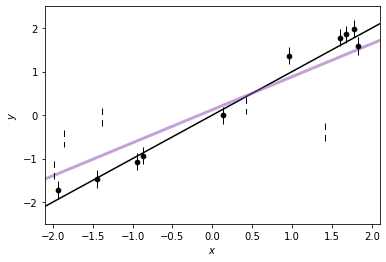

In [336]:
# First, fit the data and find the maximum likelihood model ignoring outliers.
A = np.vander(x, 2)
p = np.linalg.solve(np.dot(A.T, A / yerr[:, None]**2), np.dot(A.T, y / yerr**2))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)

# Plot the data and the truth.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
pl.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w", zorder=1000)
pl.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000)
pl.plot(x0, y0, color="k", lw=1.5)

# Plot the best fit line.
pl.plot(x0, x0 * p[0] + p[1], color="#8d44ad", lw=3, alpha=0.5)

pl.xlabel("$x$")
pl.ylabel("$y$")
pl.ylim(-2.5, 2.5)
pl.xlim(-2.1, 2.1);

DeviceArray(95., dtype=float32)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

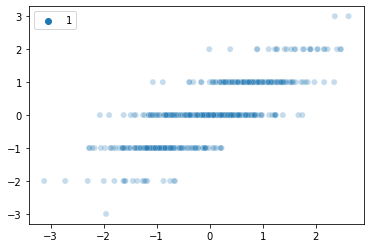

In [1069]:
from numpy.random import default_rng

def round_to_one(x):
    return jnp.round(x,0)

def round_to_five(x):
    return jnp.round(x/5,0)*5

def round_to_twenty(x):
    return jnp.round(x/20,0)*20

n_obs = 500
rg = default_rng(12345)

x = rg.normal(0,1,n_obs)
bad = rg.binomial(1, 1, n_obs)
y_true = rg.normal(0 + .75*x, .5, n_obs)
# y_obs = np.select([bad==0, bad==1], [round_to_one(y_true), round_to_twenty(y_true)])
y_obs = np.select([bad==0,bad==1], [y_true, round_to_one(y_true)])

sns.scatterplot(x, y_obs, hue=bad,alpha=.25)
# sns.histplot(y_obs,bins=50)

# from numpy.random import default_rng

# def round_to_one(x):
#     return jnp.round(x,0)

# def round_to_five(x):
#     return jnp.round(x/5,0)*5

# def round_to_ten(x):
#     return jnp.round(x/10,0)*10

# n_obs = 1000
# rg = default_rng(12345)

# x = rg.normal(0,1,n_obs)
# bad = rg.binomial(2, .8, n_obs)
# y_true = rg.normal(.5 + 1*x, .3, n_obs)*100
# y_obs = np.select([bad==0, bad==1, bad==2], [round_to_one(y_true), round_to_five(y_true), round_to_ten(y_true)])
                   

# sns.scatterplot(x, y_obs, hue=bad, alpha=.5)

In [810]:
# def round_to_one(x):
#     return jnp.round(x,0)

# this works and is the most clear, but seems sensitive to how sigma_rnd is set and idk what the right setting is in principle
# needs DiscreteHMCGibbs()
# @config_enumerate
def roundmodel(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,10))
    sd_true = numpyro.sample("sd_true", dist.HalfCauchy(10))
#     sigma_rnd = numpyro.sample("sigma_rnd", dist.HalfCauchy(.1))

    p_round = numpyro.sample("p_outlier", dist.Dirichlet(jnp.ones(2)/2))
    mu_true = alpha + beta*x

    with numpyro.plate("data", x.shape[0]):
        y_true = numpyro.sample("y_true", dist.Normal(mu_true, sd_true))
        z = numpyro.sample("z", dist.Categorical(p_round))
        yhat = jnp.select([z==0, z==1], [y_true, round_to_one(y_true)])
        numpyro.sample("yhat", dist.Normal(yhat, .001), obs=y)

# ## not clear how to make this work if there are multiple forms of rounding going on.        
# def roundmodel(x, y=None):
    
#     alpha = numpyro.sample("alpha", dist.Normal(0,10))
#     beta = numpyro.sample("beta", dist.Normal(0,10))
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
#     with numpyro.plate("data", x.shape[0]):
#         y_err = numpyro.sample("y_err", dist.Beta(1,1))
#         y_fore = alpha + beta*x
#         y_latent = numpyro.sample("y_latent", dist.Normal(y_fore, sigma))
#         numpyro.sample("yhat", dist.Normal(y_latent + (y_err-.5), .01), obs=y)

In [811]:
kernel = DiscreteHMCGibbs(NUTS(roundmodel), modified=True)
# kernel = NUTS(roundmodel)
mcmc_test = MCMC(kernel, 4000, 2000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)
# mcmc_test.print_summary()

sample: 100%|██████████| 6000/6000 [00:55<00:00, 108.96it/s, 1023 steps of size 1.18e-38. acc. prob=0.00]


In [808]:
mcmc_test.print_summary()

In [ ]:
az_data = make_arviz_data(mcmc_test, roundmodel, x)

<AxesSubplot:xlabel='yhat'>

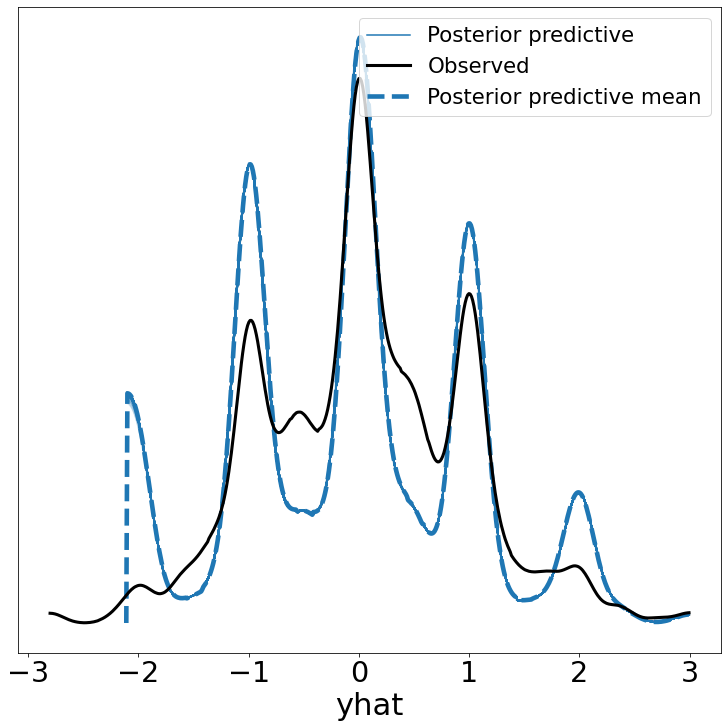

In [803]:
az.plot_ppc(data=az_data, data_pairs={"yhat":"yhat"}, num_pp_samples=500, figsize=(10,10))

In [742]:

## this is gelman's approach and it works the best
## but not clear how to make this work if there are multiple forms of rounding going on.        
def roundmodel(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
    with numpyro.plate("data", x.shape[0]):
        y_err = numpyro.sample("y_err", dist.Beta(1,1))
        y_fore = alpha + beta*x
        y_latent = numpyro.sample("y_latent", dist.Normal(y_fore, sigma))
        numpyro.sample("yhat", dist.Normal(y_latent + (y_err-.5), .01), obs=y)

# def roundmodel(x, y=None):
    
#     alpha = numpyro.sample("alpha", dist.Normal(0,10))
#     beta = numpyro.sample("beta", dist.Normal(0,10))
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(10))

# #     err_mult = jnp.array([1., 20])

#     with numpyro.plate("data", x.shape[0]):
#         err_type_p = numpyro.sample("err_type_p", dist.Dirichlet(jnp.ones(2)))
#         err_type = numpyro.sample("z", dist.Categorical(err_type_p))
# #         err_mult = jnp.matmul(jnp.array([1,20]), err_type_p)
#         y_err = numpyro.sample("y_err", dist.Beta(1,1))
#         y_fore = alpha + beta*x
#         y_latent = numpyro.sample("y_latent", dist.Normal(y_fore, sigma))
#         numpyro.sample("yhat", dist.Normal(y_latent + (y_err-.5)*err_mult, .01), obs=y)


# def roundmodel(x, y=None):
#     y_true = numpyro.sample("y_true", dist.Normal(mu_true, sd_true))
#     mu_true = ...
#     y_obs = heaping_func(y_true, params)
    

In [1070]:
kernel = NUTS(roundmodel)
mcmc_test = MCMC(kernel, 2000, 2000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)
mcmc_test.print_summary()

sample: 100%|██████████| 4000/4000 [00:24<00:00, 160.14it/s, 511 steps of size 8.15e-04. acc. prob=0.94] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha      0.03      0.19     -0.03     -0.12      0.15     11.51      1.10
        beta      0.32      0.17      0.28      0.20      0.36     16.66      1.09
p_outlier[0]      0.02      0.02      0.01      0.00      0.04      6.43      1.25
p_outlier[1]      0.98      0.02      0.99      0.96      1.00      6.43      1.25
     sd_true      0.90      0.16      0.86      0.80      0.92     15.14      1.07
   y_true[0]      0.02      0.02      0.02     -0.03      0.04      3.33      1.70
   y_true[1]     -0.05      0.02     -0.04     -0.07     -0.02      4.35      1.01
   y_true[2]     -0.59      0.01     -0.59     -0.60     -0.58      4.04      1.21
   y_true[3]     -1.35      0.01     -1.35     -1.37     -1.34      4.12      1.99
   y_true[4]     -1.30      0.01     -1.31     -1.32     -1.28      3.34      1.90
   y_true[5]     -0.78      0.06     -0.76     -0.87     -0.72      2.52      3.01
   

In [ ]:
kernel = DiscreteHMCGibbs(NUTS(roundmodel), modified=True)
kernel = NUTS(roundmodel)
mcmc_test = MCMC(kernel, 2000, 2000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)
mcmc_test.print_summary()